In [149]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random
import copy
import math
import time
import networkx as nx
import matplotlib.pyplot as plt

## Question 2: SNL with Noise Data

We use the same code as we did in Question 1 to generate the SNL problems

In [150]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [151]:
def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6., 6.])
    elif(n == 2):
        a = np.array([[-6., 15.], [-6., -15.], [8., 0.]])
    elif(n == 3):
        a = np.array([[-6., 15.,-10.], [-6., -15.,-10.], [8., 0., -10.], [0., 0., 10.]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [152]:
def SNL(a, x, d):
    sum_obj = 0
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_obj += ((np.linalg.norm(a[j] - x[i]) ** 2) - distance ** 2) ** 2
        else:
            sum_obj += (((np.linalg.norm(x[i] - x[j]) ** 2) - distance ** 2) ** 2)/2
    
    return sum_obj

# Here, we perform the gradient of the objective function
# Note that we keep the gradients for the two different
# sensors separate and stored in sum_x[0] and sum_x[1]
# respectively
def dSNL(a, x, d, npoints, n):
    sum_x = np.zeros((npoints, n))
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_x[i] += 4 * (np.linalg.norm(a[j] - x[i]) ** 2 - distance ** 2) * (-a[j] + x[i])
        else:
            sum_x[i] += 4 * (np.linalg.norm(x[i] - x[j]) ** 2 - distance ** 2) * (x[i] - x[j])

    return sum_x

# Updated steepest descent where we perform it twice for the two
# different sensors
def steepest_descent_2(op, dop, a, xin, d, niter, npoints, n):
    x = np.copy(xin)
    
    for i in range(0, niter):
            direction = dop(a, x, d, npoints, n)
            
            alpha = 1.
            
            for j in range(npoints):
                while(op(a, x  - alpha * direction, d) > op(a, x, d) \
                      - 0.5 * alpha * np.dot(direction[j], direction[j])):
                        if alpha < 1e-9:
                            break
                        alpha *= 0.9

            x -= alpha * direction
    
    return x

In [159]:
def SNL_noise(n, npoints, convex, niter, printOut = False, graph = False):
    start = time.time()
    totalRMSE = 0
    
    for iteration in range(niter):
        if convex:
            (a, p, adjacency) = generate(n, npoints)
        else:
            (a, p, adjacency) = generate_inside_hull(n, npoints)
        # Compute the Euclidian distances to the anchor points
        adjSize = len(p) + len(a)
        asize = len(a)
        d = []

        for i in range(adjSize):
            for j in range(adjSize):
                if(j > i and adjacency[i][j] > 0 and i < asize):
                    d.append((adjacency[i][j], j - asize, i, True))
                elif(j > i and adjacency[i][j] > 0):
                    d.append((adjacency[i][j], i - asize, j - asize, False))

        # Construct the CVX variables to minimize
        x = [cvx.Variable(1) for i in range(len(d) * 2)]

        T = n + npoints

        # We are working in R^2

        #This creates a 3x3 semipositive definite matrix which we will 
        #use as part of our constraints
        z = cvx.Semidef(T)

        eyeConstraint = []
        anchorConstraints = []
        pointConstraints = []

        for i in range(n):
            temp = np.zeros((T,T))
            temp[i][i] = 1
            eyeConstraint.append(temp)

        temp = np.zeros((T,T))
        for i in range(n):
            for j in range(n):
                temp[i][j] = 1
        eyeConstraint.append(temp)

        for (distance, i, j, truth) in d:
            if truth:
                temp = np.zeros(npoints)
                temp[i] = -1.
                anchorConstraints.append((np.outer(np.append(a[j], temp), np.append(a[j], temp)), distance))
            else:
                tempi = np.zeros(npoints)
                tempj = np.zeros(npoints)
                tempi[i] = 1.
                tempj[j] = 1.
                temp = tempi - tempj
                corner = np.zeros(n)
                temp = np.append(corner, temp)
                pointConstraints.append((np.outer(temp,temp), distance))

        matConstraints = anchorConstraints + pointConstraints

        #Another empty states list
        states = []

        #cost = cvx.norm(sum(x))
        cost = cvx.norm(0)
        #The four constraints in the SDP relaxation problem
        #Note that the last constraint forces z to be SPD
        constr = []

        for i, mat in enumerate(eyeConstraint):
            if i < len(eyeConstraint) - 1:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == 1)
            else:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == n)

        for i, mat in enumerate(matConstraints):
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat[0], z)) + x[2*i] - x[2*i + 1] ==  mat[1] ** 2)
            constr.append(x[2*i] >> 0)
            constr.append(x[2*i + 1] >> 0)

        constr.append(z >> 0)

        #Add the constraints and cost function
        states.append(cvx.Problem(cvx.Minimize(cost), constr))

        #Solve the SDP relaxation problem
        prob = sum(states)
        prob.solve();    

        SDPSolution = z.value.A[0:n, n:n + npoints].transpose()
        
        d2 = copy.copy(d)

        for k in range(len(d)):
            (distance, i, j, truth) = d[k]

            if not truth:
                d2.append((distance, j, i, truth))
                
        graphMSE = []
        iterList = [i for i in range(0, 100, 5)]
        if graph:
            for it in iterList:
                soln = steepest_descent_2(SNL, dSNL, a, SDPSolution, d2, it, npoints, n)
                MSE = 0
                for i in range(npoints):
                    if printOut:
                        print("Sensor " + str(i) + " is located at " + str(soln[i]) + " and the actual value is " + str(p[i]))
                    MSE += np.linalg.norm(np.asarray(soln[i]) - np.asarray(p[i]))
                graphMSE.append(MSE)
            plt.plot(iterList, graphMSE)
            plt.xlabel("Number of Iterations")
            plt.ylabel("RMSE")
            plt.show()
            
        soln = steepest_descent_2(SNL, dSNL, a, SDPSolution, d2, 200, npoints, n)
        RMSE = 0
        for i in range(npoints):
            if printOut:
                print("Sensor " + str(i) + " is located at " + str(soln[i]) + " and the actual value is " + str(p[i]))
            RMSE += np.linalg.norm(np.asarray(soln[i]) - np.asarray(p[i])) ** 2
        totalRMSE += RMSE
    
    end = time.time()
    print "Total Time Elapsed (sec): ", end - start
    print "Average RMSE: ", math.sqrt(totalRMSE / niter)

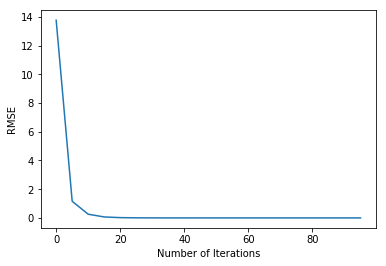

Total Time Elapsed (sec):  58.6434910297
Average RMSE:  4.57318908991e-15


In [160]:
SNL_noise(2, 10, False, 1, False, True)

In [158]:
#Performing 2-D SNL with SDP and steepest descent outside the convex hull
SNL_noise(2, 10, False, 10)

Total Time Elapsed (sec):  104.761881113
Average RMSE:  0.00162109122607
